# Chapter 10 - Regression with Functional API

In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
print(keras.__version__)

2.0.0
2.2.4-tf


## Building Cmplext Models Using the Functional API (pg. 308)

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

## example 1: connecting raw input with deep output to output

In [4]:
input_  = tf.keras.layers.Input(shape=X_train.shape[1:])
hidden1 = tf.keras.layers.Dense(30, activation='relu')(input_)
hidden2 = tf.keras.layers.Dense(30, activation='relu')(hidden1)
concat  = tf.keras.layers.Concatenate()([input_, hidden2]) # puts the raw input + hidden2 together
output  = tf.keras.layers.Dense(1)(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [5]:
model.compile(loss='mean_squared_error', optimizer='sgd')

history = model.fit(X_train, y_train,
                   validation_data=(X_valid, y_valid),
                   epochs=50, verbose=1)

Train on 11610 samples, validate on 3870 samples
Epoch 1/50
11610/11610 [==============================] - 3s 219us/sample - loss: 3.2506 - val_loss: 90.5917
Epoch 2/50
11610/11610 [==============================] - 1s 120us/sample - loss: 1.7095 - val_loss: 5.2142
Epoch 3/50
11610/11610 [==============================] - 1s 117us/sample - loss: 1.0728 - val_loss: 214.4295
Epoch 4/50
11610/11610 [==============================] - 1s 118us/sample - loss: 9.4388 - val_loss: 7.6930
Epoch 5/50
11610/11610 [==============================] - 1s 119us/sample - loss: 1.4097 - val_loss: 2.4377
Epoch 6/50
11610/11610 [==============================] - 1s 125us/sample - loss: 0.7191 - val_loss: 0.6876
Epoch 7/50
11610/11610 [==============================] - 2s 132us/sample - loss: 0.3810 - val_loss: 1.0734
Epoch 8/50
11610/11610 [==============================] - 2s 210us/sample - loss: 0.4676 - val_loss: 0.4982
Epoch 9/50
11610/11610 [==============================] - 2s 140us/sample - loss: 0.

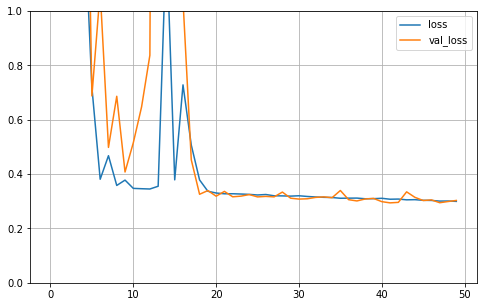

In [6]:
# HDF5 format saves architecture, parameters, optimizer, connection weights, biases
#model.save('my_model.h5')
#model = tf.keras.models.load_model('my_keras_model.h5')

import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


mse_test = model.evaluate(X_test, y_test, verbose=0)
X_new = X_test[:3] #"new instances"
y_pred = model.predict(X_new)

## example 2: sending 2 different subsets of features (possibly overlaping) through the wide and deep paths

In [7]:
input_A  = tf.keras.layers.Input(shape=[5], name='wide_input')
input_B  = tf.keras.layers.Input(shape=[6], name='deep_input')

hidden1 = tf.keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = tf.keras.layers.Dense(30, activation='relu')(hidden1)
concat  = tf.keras.layers.Concatenate()([input_A, hidden2]) # puts the raw input_A + hidden2 (input_B) together

# input_A gots to output layer unprocessed
output  = tf.keras.layers.Dense(1, name='output')(concat)

model = tf.keras.Model(inputs=[input_A, input_B], outputs=[output])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-3)) #0.001

In [8]:
                          #feats 0-4     #feats 2-7
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

In [9]:
# alternative to "(X_train_A, X_train_B)":
# {'wide_input': X_train_A, 'deep_input':X_train_B}

# this way there's no confusion as to which input should go where
history = model.fit((X_train_A, X_train_B), y_train,
                    validation_data=((X_valid_A, X_valid_B), y_valid),
                    epochs=20, verbose=1)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 200us/sample - loss: 2.5289 - val_loss: 1.2680
Epoch 2/20
11610/11610 [==============================] - 2s 149us/sample - loss: 0.9137 - val_loss: 0.8379
Epoch 3/20
11610/11610 [==============================] - 2s 155us/sample - loss: 0.7341 - val_loss: 0.7183
Epoch 4/20
11610/11610 [==============================] - 2s 185us/sample - loss: 0.6747 - val_loss: 0.6629
Epoch 5/20
11610/11610 [==============================] - 1s 129us/sample - loss: 0.6417 - val_loss: 0.6360
Epoch 6/20
11610/11610 [==============================] - 1s 122us/sample - loss: 0.6176 - val_loss: 0.6068
Epoch 7/20
11610/11610 [==============================] - 1s 110us/sample - loss: 0.5978 - val_loss: 0.5900
Epoch 8/20
11610/11610 [==============================] - 2s 170us/sample - loss: 0.5804 - val_loss: 0.5740
Epoch 9/20
11610/11610 [==============================] - 2s 155us/sample - loss: 0.565

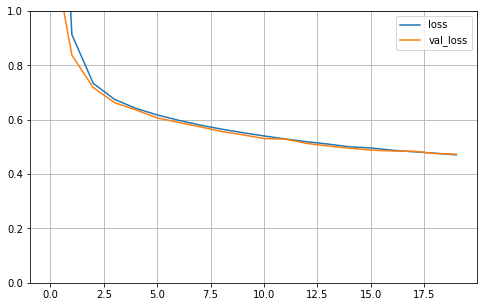

In [10]:
# HDF5 format saves architecture, parameters, optimizer, connection weights, biases
#model.save('my_model.h5')
#model = tf.keras.models.load_model('my_keras_model.h5')

mse_test = model.evaluate((X_test_A, X_test_B), y_test, verbose=0)
y_pred = model.predict((X_new_A, X_new_B))

import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
#plt.gca().set_xlim(17, 20)
plt.show()

## Add an auxiliar output and set weights

In [11]:
input_A  = tf.keras.layers.Input(shape=[5], name='wide_input')
input_B  = tf.keras.layers.Input(shape=[6], name='deep_input')

hidden1 = tf.keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = tf.keras.layers.Dense(30, activation='relu')(hidden1)
concat  = tf.keras.layers.Concatenate()([input_A, hidden2]) # puts the raw input_A + hidden2 (input_B) together

# input_A gots to output layer unprocessed
output  = tf.keras.layers.Dense(1, name='main_output')(concat)
aux_output = tf.keras.layers.Dense(1, name='aux_output')(hidden2)

model = tf.keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

loss_functions = {'main_output':'mse',
                  'aux_output' :'mse'}
loss_weights = {'main_output':0.9, # give more weight to main output
                'aux_output' :0.1}
model.compile(loss=loss_functions,
              loss_weights=loss_weights,
              optimizer=tf.keras.optimizers.SGD(lr=1e-3)) #0.001

In [12]:
# alternative to "(X_train_A, X_train_B)":
# {'wide_input': X_train_A, 'deep_input':X_train_B}

# this way there's no confusion as to which input should go where
history = model.fit((X_train_A, X_train_B), (y_train, y_train), # 2 outputs, 2 y's
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)),
                    epochs=20, verbose=1)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 4s 312us/sample - loss: 2.2409 - main_output_loss: 1.9586 - aux_output_loss: 4.7785 - val_loss: 1.7023 - val_main_output_loss: 1.4607 - val_aux_output_loss: 3.8757
Epoch 2/20
11610/11610 [==============================] - 2s 133us/sample - loss: 1.1237 - main_output_loss: 0.8969 - aux_output_loss: 3.1631 - val_loss: 1.1871 - val_main_output_loss: 1.0256 - val_aux_output_loss: 2.6410
Epoch 3/20
11610/11610 [==============================] - 2s 133us/sample - loss: 0.9093 - main_output_loss: 0.7627 - aux_output_loss: 2.2309 - val_loss: 0.9560 - val_main_output_loss: 0.8330 - val_aux_output_loss: 2.0635
Epoch 4/20
11610/11610 [==============================] - 2s 133us/sample - loss: 0.8102 - main_output_loss: 0.7015 - aux_output_loss: 1.7905 - val_loss: 0.8486 - val_main_output_loss: 0.7462 - val_aux_output_loss: 1.7701
Epoch 5/20
11610/11610 [==============================] - 2s 13

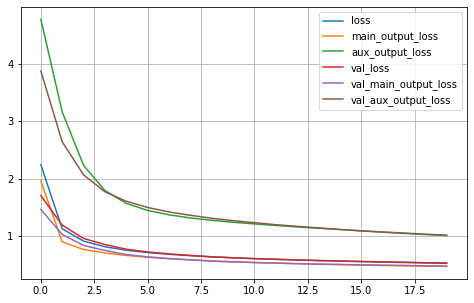

In [13]:
# 2 outputs, more sets of results
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B),
                                                 (y_test, y_test),
                                                 verbose=0)
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
#plt.gca().set_xlim(17, 20)
plt.show()

In [ ]:
# HDF5 format saves architecture, parameters, optimizer, connection weights, biases
#model.save('my_model.h5')
#model = tf.keras.models.load_model('my_keras_model.h5')

## Running with callbacks

In [15]:
# checkpoint model
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('my_keras_model.h5',
                                                   save_best_only=True)

# early stopping (if no training progress is observed)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

# log to tensorboard
import os
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)


# fit
history = model.fit((X_train_A, X_train_B), (y_train, y_train), # 2 outputs, 2 y's
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)),
                    epochs=100,
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 2s 172us/sample - loss: 0.5163 - main_output_loss: 0.4630 - aux_output_loss: 0.9958 - val_loss: 0.5227 - val_main_output_loss: 0.4710 - val_aux_output_loss: 0.9884
Epoch 2/100
11610/11610 [==============================] - 2s 165us/sample - loss: 0.5101 - main_output_loss: 0.4580 - aux_output_loss: 0.9790 - val_loss: 0.5167 - val_main_output_loss: 0.4662 - val_aux_output_loss: 0.9713
Epoch 3/100
11610/11610 [==============================] - 2s 144us/sample - loss: 0.5048 - main_output_loss: 0.4537 - aux_output_loss: 0.9633 - val_loss: 0.5122 - val_main_output_loss: 0.4631 - val_aux_output_loss: 0.9543
Epoch 4/100
11610/11610 [==============================] - 2s 154us/sample - loss: 0.4989 - main_output_loss: 0.4491 - aux_output_loss: 0.9475 - val_loss: 0.5073 - val_main_output_loss: 0.4594 - val_aux_output_loss: 0.9387
Epoch 5/100
11610/11610 [==============================] - 

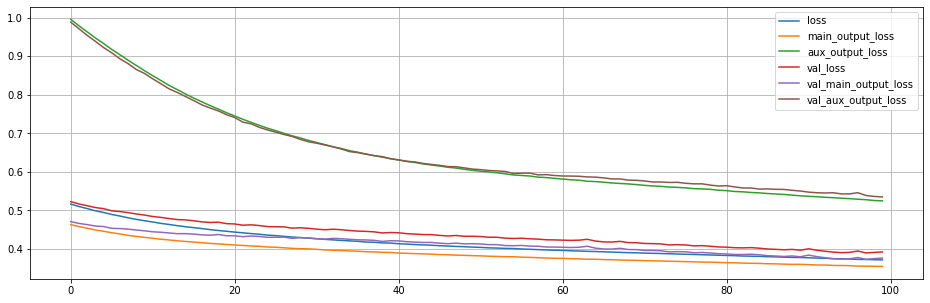

In [16]:
# 2 outputs, more sets of results
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B),
                                                 (y_test, y_test),
                                                 verbose=0)
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(16, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
#plt.gca().set_xlim(17, 20)
plt.show()

In [18]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 66068), started 0:01:45 ago. (Use '!kill 66068' to kill it.)

In [22]:
import numpy as np

import os
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(test_logdir)
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar('my_scalar', np.sin(step / 10), step=step)
        
        data = (np.random.randn(100) + 2) * step / 100 # some random data
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        
        images = np.random.randn(2, 32, 32, 3) # random 32x32 RGB images
        tf.summary.image('my_images', images * step / 1000, step=step)
        
        texts = ['The step is ' + str(step), "Its square is " + str(step ** 2)]
        tf.summary.text('my_text', texts, step=step)
        
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio('my_audio', audio, sample_rate=48000, step=step)

tensorboard_cb = tf.keras.callbacks.TensorBoard(test_logdir)


# fit
history = model.fit((X_train_A, X_train_B), (y_train, y_train), # 2 outputs, 2 y's
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)),
                    epochs=100,
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 3s 224us/sample - loss: 0.3705 - main_output_loss: 0.3535 - aux_output_loss: 0.5236 - val_loss: 0.3862 - val_main_output_loss: 0.3695 - val_aux_output_loss: 0.5369
Epoch 2/100
11610/11610 [==============================] - 2s 144us/sample - loss: 0.3700 - main_output_loss: 0.3529 - aux_output_loss: 0.5227 - val_loss: 0.3889 - val_main_output_loss: 0.3725 - val_aux_output_loss: 0.5367
Epoch 3/100
11610/11610 [==============================] - 2s 141us/sample - loss: 0.3695 - main_output_loss: 0.3525 - aux_output_loss: 0.5214 - val_loss: 0.3892 - val_main_output_loss: 0.3732 - val_aux_output_loss: 0.5333
Epoch 4/100
11610/11610 [==============================] - 2s 172us/sample - loss: 0.3686 - main_output_loss: 0.3517 - aux_output_loss: 0.5198 - val_loss: 0.3864 - val_main_output_loss: 0.3700 - val_aux_output_loss: 0.5338
Epoch 5/100
11610/11610 [==============================] - 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006